In [1]:
import xarray as xr
import gribscan

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import intake

## Short version: Get surface 2D data for tco2559-ng5-cycle3 and make a plot

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [4]:
# which IFS experiments are available?
print(list(cat.IFS))

['IFS_4.4-FESOM_5-cycle3', 'tco2559-ng5-cycle3']


In [5]:
# which other streams are in the IFS catalog?
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 

['2D_1h_native', '3D_6h_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', 'WAM_1h_native']


In [7]:
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['WAM_1h_native'].to_dask() # pick highest frequency (1-hourly), highest spatial resolution (4.4km)

#### list all 2D variables; click arrow next to 'Data variables" to see the list; click the icons at the end of each row for more info, such as long name and shape

In [8]:
data

<xarray.Dataset>
Dimensions:  (time: 25849, value: 2612294)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Data variables:
    cdww     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    dwi      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwd      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwp      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    pp1d     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    swh      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    wind     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

#### Get the model IFS grid (points_ifs)

In [9]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

#### Interpolate an example variable to a small target grid; here: zoom of Europe (lon2, lat2)

In [10]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

#### Pick the example variable and do the actual interpolation

In [11]:
data_sample = data['swh'][1,:] # significant wave height

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

#### Plot it

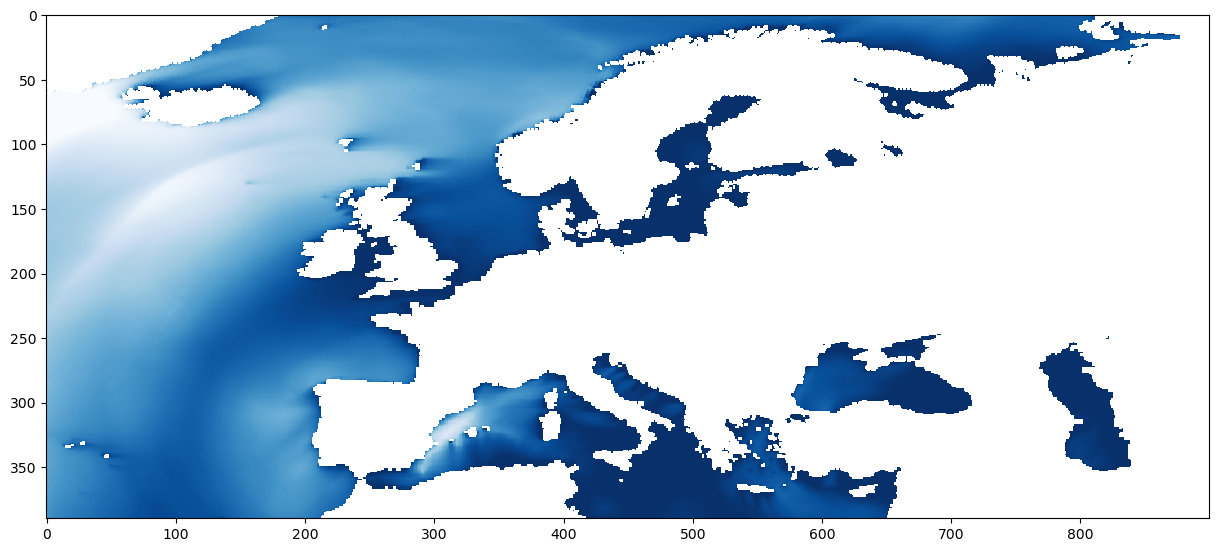

In [12]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn), cmap=cm.Blues_r, vmin=1., vmax=9.)
#plt.colorbar()

## Longer version

In [17]:
data['swh'] # pick any variable here

<xarray.DataArray 'swh' (time: 25849, value: 2612294)>
dask.array<open_dataset-6246931ed9bb986d368fdab9a1f3651bswh, shape=(25849, 2612294), dtype=float64, chunksize=(1, 2612294), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    140229
    dataType:                   fc
    numberOfPoints:             2612294
    typeOfLevel:                meanSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Significant height of combined wind waves and...
    cfVarName:                  swh
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

look at the variables by taking the first time step, but all spatial points

In [18]:
data_sample = data['swh'][1,:]
data_sample

<xarray.DataArray 'swh' (value: 2612294)>
dask.array<getitem, shape=(2612294,), dtype=float64, chunksize=(2612294,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    140229
    dataType:                   fc
    numberOfPoints:             2612294
    typeOfLevel:                meanSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Significant height of combined wind waves and...
    cfVarName:                  swh
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

In [19]:
data_sample.shape # the number of points

(2612294,)

In [20]:
data_sample.values # access the actual values, this can take a short moment

array([nan, nan, nan, ..., nan, nan, nan])

In [21]:
nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan]) # create an interpolator, this takes a moment 

In [22]:
interpolated_nn = nn_interpolation((lon2, lat2)) # this step is quite fast and performs the actual interpolation to the target grid

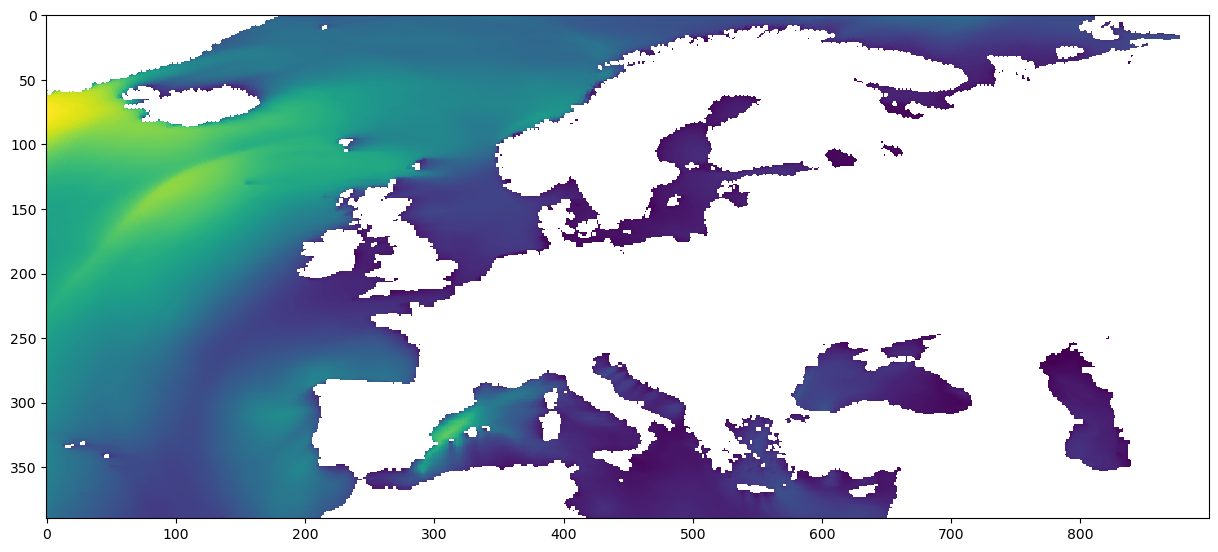

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find a point on the map and plot timeseries

In [24]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [25]:
# the point we are interesting in
lon_target = -10
lat_target = 50

In [26]:
points = np.array([[lat_target],[lon_target]])

In [27]:
index = tunnel_fast1d(model_lon, model_lat, points)

In [28]:
# in the model, this is the point
model_lon[index[0]], model_lat[index[0]]

(350.08639308855294, 50.0)

In [29]:
data['swh'] # first dimension is time, second dimension is spatial dimension

<xarray.DataArray 'swh' (time: 25849, value: 2612294)>
dask.array<open_dataset-6246931ed9bb986d368fdab9a1f3651bswh, shape=(25849, 2612294), dtype=float64, chunksize=(1, 2612294), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    140229
    dataType:                   fc
    numberOfPoints:             2612294
    typeOfLevel:                meanSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Significant height of combined wind waves and...
    cfVarName:                  swh
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

In [30]:
data['swh'][:, index[0]] # this would read all time steps for this point 

<xarray.DataArray 'swh' (time: 25849)>
dask.array<getitem, shape=(25849,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Attributes: (12/15)
    paramId:                    140229
    dataType:                   fc
    numberOfPoints:             2612294
    typeOfLevel:                meanSea
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Significant height of combined wind waves and...
    cfVarName:                  swh
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

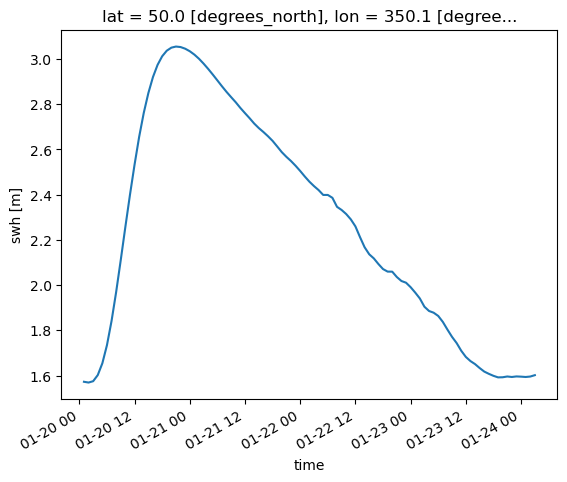

In [31]:
data['swh'][1:100, index[0]].plot() # just plot the first 100 steps, note the actual time is plotted on the x axis as well

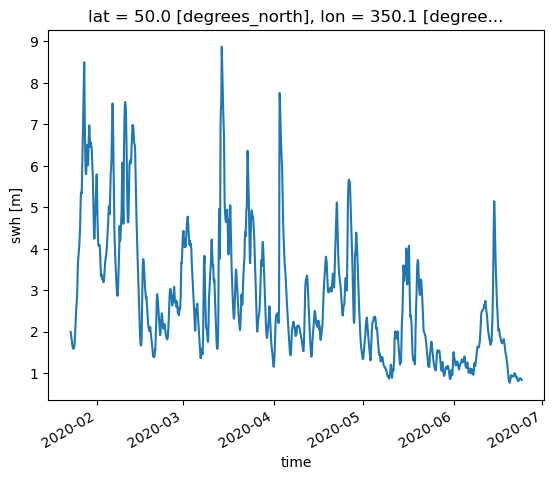

In [32]:
data['swh'].sel(time=slice('2020-01-23','2020-06-23'))[:,index[0]].plot() # plot five months